## Exploration 12. MakeChatbot 💬

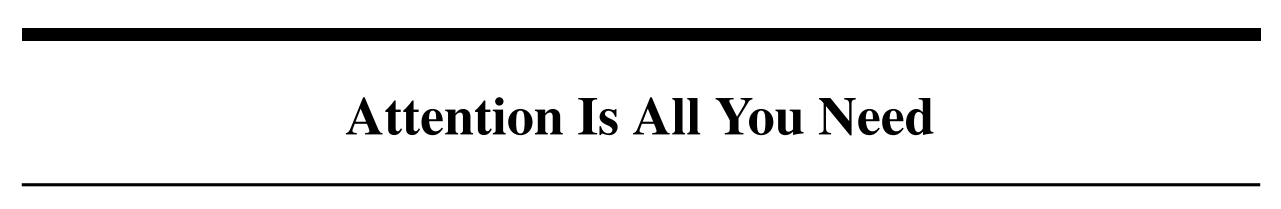

### Table of Centents

### 1. Introduction

* 1.1 Limitations of seq2seq Model
* 1.2 What is Transformer? (Simply)
* 1.3 Transformer's Main Hyperparameters

### 2. Understanding Transformer(1) (A High-Level Look)

### 3. Understanding Transformer(2) (A Low-Level(Tensor) Look)

### 4. Transformer

* 4.1 Positional Encoding
* 4.2 Attention
* 4.3 Encoder Self-Attention
* 4.4 Position-wise FFNN
* 4.5 Residual connection and Layer Normalization
* 4.6 From Encoder To Decoder
* 4.7 Decoder First Sub-Layer : Self-Attention and Look Ahead Mask
* 4.8 Decoder Second Sub-Layer : Encoder-Decoder Attention
* 4.9 The Decoder Side
* 4.10 The Final Linear and Softmax Layer

### 5. Recap Of Training

* 5.1 Encoding
* 5.2 Loss Function

### 6. Import Libraries

### 7. Transformer Implementation

* 7.1 Positional Encoding
* 7.2 Scaled dot-product Attention + Mask
* 7.3 Multi-head Attention
* 7.4 Mask
* 7.5 Position-wise FFNN
* 7.6 Encoder
* 7.7 Decoder
* 7.8 Transformer
* 7.9 Loss Function
* 7.10 Learning Rate Scheduler

### 8. Make Chatbot

* 8.1 Load Data
* 8.2 Data Preprocessing
* 8.3 Create Vocabulary
* 8.4 Integer Encoding and Padding
* 8.5 Using Teacher Forcing

### 9. Model Defining and Training

### 10. Testing Chatbot

### 11. Retrospection

***

### 1. Introduction

### 1.1 Limitations of seq2seq Model

기존의 seq2seq 모델은 인코더-디코더 구조로 구성되어져 있었다. 여기서 인코더는 입력 시퀀스를 하나의 벡터 표현으로 압축하고, 디코더는 이 벡터 표현을 통해서 출력 시퀀스를 만들어냈다. 하지만 이러한 구조는 인코더가 입력 시퀀스를 하나의 벡터로 압축하는 과정에서 입력 시퀀스의 정보가 일부 손실된다는 단점이 있었고, 이를 보정하기 위해 어텐션이 사용되었다. 그런데 어텐션을 RNN의 보정을 위한 용도로서 사용하는 것이 아니라 어텐션만으로 인코더와 디코더를 만들어보면 어떨까?

### 1.2 What is Transformer? (Simply)

트랜스포머는 2017년 구글이 발표한 논문인 "Attention is all you need"에서 나온 모델로 기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션만으로 구현한 모델이다. 이 모델은 RNN을 사용하지 않고, 인코더-디코더 구조를 설계하였음에도 번역 성능에서도 RNN보다 우수한 성능을 보여주었다.

### 1.3 Transformer's Main Hyperparameters

시작에 앞서 트랜스포머의 하이퍼파라미터를 정의한다. 아래에서 정의하는 수치는 트랜스포머를 제안한 논문에서 사용한 수치로 하이퍼파라미터는 사용자가 모델 설계시 임의로 변경할 수 있는 값들이다.

* $d_{model}$ = 512

트랜스포머의 인코더와 디코더에서의 정해진 입력과 출력의 크기를 의미한다. 임베딩 벡터의 차원 또한 $d_{model}$이며, 각 인코더와 디코더가 다음 층의 인코더와 디코더로 값을 보낼 때에도 이 차원을 유지한다.

* $num\_layer$ = 6

트랜스포머에서 하나의 인코더와 디코더를 층으로 생각하였을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미한다.

* $num\_heads$ = 8

트랜스포머에서는 어텐션을 사용할 때, 한 번 하는 것 보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택했다. 이때 이 병렬의 개수를 의미한다.

* $d_{ff}$ = 2048

트랜스포머 내부에는 피드 포워드 신경망이 존재하며 해당 신경망의 은닉층의 크기를 의미한다. 피드 포워드 신경망의 입력층과 출력층의 크기는 같다.

### 2. Understanding Transformer(1) (A High-Level Look)

* 트랜스포머 부분을 하나의 블랙박스로 보자. 기계 번역의 경우를 예로 들면, 모델은 어떤 한 언어로 된 하나의 문장을 입력으로 받아 다른 언어로 된 번역을 출력으로 내놓을 것이다. 

<img src='https://nlpinkorean.github.io/images/transformer/the_transformer_3.png' height="300" width="600">

<img src='https://nlpinkorean.github.io/images/transformer/The_transformer_encoder_decoder_stack.png' height="300" width="600">

* 위 블랙박스를 열어 보게 되면 인코더 부분, 디코더 부분, 그리고 그 사이를 이어주는 연결고리들을 볼 수 있다. 
* 트랜스포머는 RNN을 사용하지 않지만 기존의 seq2seq처럼 인코더에서 입력 시퀀스를 입력받고, 디코더에서 출력 시퀀스를 출력하는 인코더-디코더 구조를 유지하고 있다. 
* 이전 seq2seq 구조에서는 인코더와 디코더에서 각각 하나의 RNN이 t개의 시점(time step)을 가지는 구조였다면 이번에는 인코더와 디코더라는 단위가 N개로 구성되는 구조이다.
  * 인코더 부분: 여러 개의 인코더를 쌓아 올려 만든 것.
  * 디코더 부분 : 인코더 부분과 동일한 개수만큼의 디코더를 쌓은 것.

(논문에서는 6개를 쌓았지만, 꼭 6개를 쌓아야 하는 것은 아니고 각자의 세팅에 맞게 얼마든지 변경하여 실험할 수 있다.)

* 인코더들은 모두 똑같은 구조를 가지고 있다.(하지만 인코더들 간에 같은 가중치를 공유하지는 않는다.) 
* 하나의 인코더를 나눠보면 아래와 같이 두 개의 sub-layer로 구성되어 있다.

<img src='https://nlpinkorean.github.io/images/transformer/Transformer_encoder.png' height="250" width="500">

* 인코더에 들어온 입력은 일단 먼저 Self-Attention layer를 지나게 된다. 
* Self-Attention layer를 통과하여 나온 출력은 다시 Feed-Forward Neural Network layer(FFNN)으로 들어가게 된다. 
* 똑같은 FFNN이 각 위치의 단어마다 독립적으로 적용돼 출력을 만든다.
* Self-Attention layer : 인코더가 하나의 특정한 단어를 인코드하기 위해서 입력 내의 모든 다른 단어들과의 관계를 살펴본다.

<img src='https://nlpinkorean.github.io/images/transformer/Transformer_decoder.png' height="300" width="600">

* 디코더 또한 인코더에 있는 두 layer 모두를 가지고 있다. 
* 그러나 그 두 층 사이에 seq2seq 모델의 어텐션과 비슷한 Encoder-Decoder Attention 이 포함되어 있다. 
* 이는 디코더가 입력 문장 중에서 각 타임 스텝에서 가장 관련 있는 부분에 집중할 수 있도록 해준다.

### 3. Understanding Transformer(2) (A Low-Level(Tensor) Look)

* 최근의 NLP 관련한 대부분 모델들처럼 트랜스포머도 입력 단어들을 인코딩 알고리즘을 통해 벡터로 바꾸어준다. 
* 각 단어들은 크기 512의 벡터 하나로 임베딩된다.(논문 기준)

<img src='https://nlpinkorean.github.io/images/transformer/embeddings.png' height="300" width="600">

* 이 임베딩은 가장 밑단의 인코더에서만 일어난다. 이렇게 되면 아래와 같이 표현할 수 있게 된다. 

<img src='https://nlpinkorean.github.io/images/transformer/encoder_with_tensors.png' height="300" width="600">

* 모든 인코더들은 크기 512의 벡터 리스트를 입력으로 받는다. (이 벡터는 가장 밑단의 인코더 입장에서는 word embedding이 될 것이고, 다른 인코더들 입장에서는 바로 전의 인코더의 출력일 것이다. 벡터 리스트 사이즈는 hyperparameter로 마음대로 정할 수 있다. 일반적으로는 가장 긴 문장의 길이로 둔다.) 
* 입력 문장의 단어들을 임베딩한 후에, 각 단어에 해당하는 벡터들은 인코더 내의 두 개의 sub-layer로 들어가게 된다.
* 여기에서 각 위치에 있는 단어가 그 단어만의 path를 통해 인코더에 흘러간다는 크랜스포머 모델의 주요 성질을 볼 수 있다. 
* Self-Attention layer에는 각 path들 사이에 dependency가 있다. 
* 반면, FFNN layer는 이런 dependency가 없기 때문에 다양한 path들은 병렬처리가 가능하다.

<img src='https://nlpinkorean.github.io/images/transformer/encoder_with_tensors_2.png' height="300" width="600">

* 인코더는 입력으로 벡터들의 리스트를 받는다. 
* 이 리스트를 먼저 Self-Attention layer에, 그다음으로 FFNN layer에 통과시키고 그 결과물을 그다음 인코더에게 전달한다. 
* 각 위치의 단어들은 각각 다른 self-encoding 과정을 거친다. 그 다음으로 모두에게 같은 과정인 FFNN layer를 거친다. 

### 4. Transformer

### 4.1 Positional Encoding

<img src='https://wikidocs.net/images/page/31379/transformer5_final_final.PNG' height="500" width="500">

* 이때까지 살펴본 트랜스포머에서 한 가지 부족한 부분은 이 모델이 입력 문장에서 단어들의 순서에 대해서 고려하고 있지 않다는 점이다. 
* RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서 처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수 있다는 점에 있었다. 
* 하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를 다른 방식으로 알려줄 필요가 있다.
* 트랜스포머는 단어의 위치 정보를 얻기 위해서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데, 이를 **Positional Encoding(포지셔널 인코딩)**이라고 한다.
* 위의 그림은 입력으로 사용되는 임베딩 벡터들이 트랜스포머의 입력으로 사용되기 전에 포지셔널 인코딩의 값이 더해지는 것을 보여줍니다.
* 임베딩 벡터가 인코더의 입력으로 사용되기 전 포지셔널 인코딩값이 더해지는 과정을 시각화하면 아래와 같다.

<img src='https://wikidocs.net/images/page/31379/transformer6_final.PNG' height="500" width="500">

* 트랜스포머는 위치 정보를 가진 값을 만들기 위해서 아래의 두 개의 함수를 사용한다.
$$
PE_{(pos, 2i)}  =  sin(pos/10000^{2i/d_{model}}) \\
PE_{(pos, 2i+1)}  =  cos(pos/10000^{2i/d_{model}})
$$

* 사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해볼 수 있는데, 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해주므로서 단어의 순서 정보를 더하여 준다.
* 그런데 위의 두 함수에는 $pos$, $i$, $d_{model}$ 등의 생소한 변수들이 있다.
* 위의 함수를 이해하기 위해서는 위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 한다.

<img src='https://wikidocs.net/images/page/31379/transformer7.PNG' height="350" width="350">

* $pos$는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, $i$는 임베딩 벡터 내의 차원의 인덱스를 의미한다. 위의 식에 따르면 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을 사용하고 홀수인 경우에는 코사인 함수의 값을 사용한다.
* 위의 식에서 $d_{model}$은 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터이다. (임베딩 벡터 또한 $d_{model}$의 차원을 가지는데 위의 그림에서는 마치 4로 표현되었지만 실제 논문에서는 512의 값을 가진다.)
* 위와 같은 Positional Encoding(포지셔널 인코딩)을 사용하면 순서 정보가 보존되는데, 예를 들어 각 임베딩 벡터에 Positional Encoding(포지셔널 인코딩)의 값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라진다. 
* 이에 따라 트랜스포머의 입력은 순서 정보가 고려된 임베딩 벡터가 된다. 
* Positional Encoding(포지셔널 인코딩)의 값 추가하기로 한 배경에는 이 값들을 단어들의 임베딩에 추가하는 것이 Query/Key/Value 벡터들로 나중에 투영되었을 때 단어들 간의 거리를 늘릴 수 있다는 점이다.

* 실제로는 이 패턴이 어떻게 될까?
* 그림에서 각 행은 하나의 벡터에 대한 Positional Encoding(포지셔널 인코딩)에 해당한다. 그러므로 첫 번째 행은 우리가 입력 문장의 첫 번째 단어의 임베딩 벡터에 더할 Positional Encoding 벡터이다. 
* 각 행은 사이즈 512인 즉, 512개의 셀을 가진 벡터이며 각 셀의 값은 1과 -1 사이를 가진다.
* 다음 그림에서는 이 셀들의 값들에 대해 색깔을 다르게 나타내어 Positional Encoding 벡터들이 가지는 패턴을 볼 수 있도록 시각화한 것이다.

<img src='https://nlpinkorean.github.io/images/transformer/transformer_positional_encoding_large_example.png' height="500" width="500">

* 20개의 단어와 임베딩 크기가 512인 Positional Encoding의 실제 예시이다.
* 그림에서도 볼 수 있듯이 벡터의 중간 부분이 반으로 나눠져있다.
* 그 이유가 반은 sine 함수에 의해서 생성되었고, 나머지 반은 cosine 함수에 의해 생성되었기 때문이다. 
* 이 두 값들은 연결되어 하나의 Positional Encoding 벡터를 이루고 있다. 

### 4.2 Attention

* 트랜스포머에서 사용되는 세 가지의 어텐션에 대해서 간단히 정리해보자.

<img src='https://wikidocs.net/images/page/31379/attention.PNG' height="100" width="200">

* 첫번째 그림인 셀프 어텐션은 인코더에서 이루어지지만, 두번째 그림인 셀프 어텐션과 세번째 그림인 인코더-디코더 어텐션은 디코더에서 이루어진다. 
* 셀프 어텐션은 본질적으로 Query, Key, Value가 동일한 경우를 말한다. 
* 반면, 세번째 그림 인코더-디코더 어텐션에서는 Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터이므로 셀프 어텐션이라고 부르지 않는다.
* 주의할 점은 여기서 Query, Key 등이 같다는 것은 벡터의 값이 같다는 것이 아니라 벡터의 출처가 같다는 의미이다.
* 정리하면 다음과 같다.

```
인코더의 셀프 어텐션 : Query = Key = Value
디코더의 마스크드 셀프 어텐션 : Query = Key = Value
디코더의 인코더-디코더 어텐션 : Query : 디코더 벡터 / Key = Value : 인코더 벡터
```

<img src='https://wikidocs.net/images/page/31379/transformer_attention_overview.PNG' height="250" width="500">

* 위 그림은 트랜스포머의 아키텍처에서 세 가지 어텐션이 각각 어디에서 이루어지는지를 보여준다. 세 개의 어텐션에 추가적으로 'Multi-Head(멀티 헤드)'라는 이름이 붙어있는데, 이는 트랜스포머가 어텐션을 병렬적으로 수행하는 방법을 의미한다.

### 4.3 Encoder Self-Attention

* 다음 문장을 내가 번역하고 싶은 문장이라고 보자. : `“그 동물은 길을 건너지 않았다 왜냐하면 그것은 너무 피곤했기 때문이다”`
* 여기에서 `그것`은 `동물`일 것이다.
* `그것 = 동물`이라는 것이 사람에게는 너무나도 간단하지만 모델에게는 그렇게 간단한 문제가 아니다. 
* 모델이 `그것은`이라는 단어를 처리할 때, 모델은 Self-Attention을 이용하여 `그것`과 `동물`을 연결할 수 있다. 
* Self-Attention은 입력 문장 내의 단어들끼리 유사도를 구하므로서 `그것(it)`이 `동물(animal`)과 연관되었을 확률이 높다는 것을 찾아낸다.

<img src='https://wikidocs.net/images/page/31379/transformer10.png' height="100" width="250">

### 4.3.1 Calculation Process of Self-Attention

### 1) First Step of Self-Attention (Get Q, K, V Vectors)

* Self-Attention은 인코더의 초기 입력인 $d_{model}$의 차원을 가지는 단어 벡터들을 사용하여 Self-Attention을 수행하는 것이 아니다. 
* 우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거친다. 
* 이때 이 Q벡터, K벡터, V벡터들은 초기 입력인 $d_{model}$의 차원을 가지는 단어 벡터들보다 더 작은 차원을 가지는데, 논문에서는 $d_{model}$=512의 차원을 가졌던 각 단어 벡터들을 64의 차원을 가지는 Q벡터, K벡터, V벡터로 변환한다.
* 그러나 꼭 이렇게 더 작아야만 하는 것은 아니며, 단지 Multi-Head Attention의 계산 복잡도를 일정하게 만들고자 내린 구조적인 선택일 뿐이다.
* 64라는 값은 트랜스포머의 또 다른 하이퍼파라미터인 $num\_heads$로 인해 결정되는데, 트랜스포머는 $d_{model}$을 $num\_heads$로 나눈 값을 각 Q벡터, K벡터, V벡터의 차원으로 결정한다. 
* 논문에서는 $num\_heads$를 8로 하였다.

<img src='https://wikidocs.net/images/page/31379/transformer11.PNG' height="200" width="250">

* 기존의 벡터로부터 더 작은 벡터는 가중치 행렬을 곱하므로서 완성된다. 
* 각 가중치 행렬은 $d_{model}X(d_{model}/num\_heads)$의 크기를 가진다. 이 가중치 행렬은 훈련 과정에서 학습된다.
* 각 가중치 행렬은 $d_{model}$=512이고 $num\_heads$=8이라면, 각 벡터에 3개의 서로다른 가중치 행렬을 곱하고 64의 크기를 가지는 Q, K, V 벡터를 얻어낸다. 
* 위의 그림은 단어 벡터 중 student벡터로부터 Q,K,V 벡터를 얻어내는 모습을 보여준다.
* 모든 단어 벡터에 위와 같은 과정을 거치면 I,am, a, student는 각각의 Q, K, V 벡터를 얻는다.

### 2) Second Step of Self-Attention

* 단어와 입력 문장 속의 다른 모든 단어들에 대해서 각각 점수를 계산한다. 
* 이 점수는 현재 위치의 이 단어를 인코드할 때 다른 단어들에 대해서 얼마나 집중을 해야 할지를 결정한다.
* 점수는 현재 단어의 Query 벡터와 점수를 매기려 하는 다른 위치에 있는 단어의 Key 벡터의 내적으로 계산된다. 
* 다시 말해, 위치 #1에 있는 단어에 대해서 Self-Attention을 계산한다 했을 때, 첫 번째 점수는 $q_1$과 $k_1$의 내적일 것이다. 그리고 동일하게 두 번째 점수는 $q_1$과 $k_2$의 내적일 것이다.

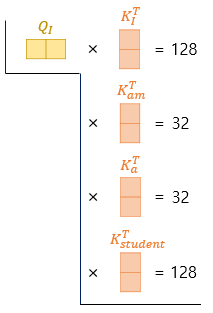

### 3) Third, Tourth Step of Self-Attention (Scaled dot-product Attention)

*  트랜스포머에서는 어텐션 함수로 $score(q,k) = q∙k~/\sqrt{n}$를 사용한다.
* 이러한 함수를 사용하는 어텐션을 Dot-product Attention(닷-프로덕트 어텐션)에서 값을 스케일링하는 것을 추가하였다고 하여 **Scaled dot-product Attention(스케일드 닷-프로덕트 어텐션)**이라고 한다.
.

<img src='https://wikidocs.net/images/page/31379/transformer13.PNG' height="400" width="400">

* 지금부터 설명하는 과정은 am에 대한 Q벡터, a에 대한 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 거친다.
* 위의 그림은 단어 I에 대한 Q벡터가 모든 K벡터에 대해서 어텐션 스코어를 구하는 것을 보여준다.
* 위의 128과 32는 임의로 가정한 수치로 신경쓰지 않아도 좋다.
* 위의 그림에서 어텐션 스코어는 각각 단어 I가 단어 I, am, a, student와 얼마나 연관되어 있는지를 보여주는 수치이다.
* 트랜스포머에서는 두 벡터의 내적값을 스케일링하는 값으로 K벡터의 차원을 나타내는 $d_k$에 루트를 씌운 $\sqrt{d_k}$ 사용하는 것을 택했다.
* 앞서 언급하였듯이 논문에서 $d_k$는 $d_{model}/num\_heads$라는 식에 따라서 64의 값을 가지므로 $\sqrt{d_k}$는 8의 값을 가진다.

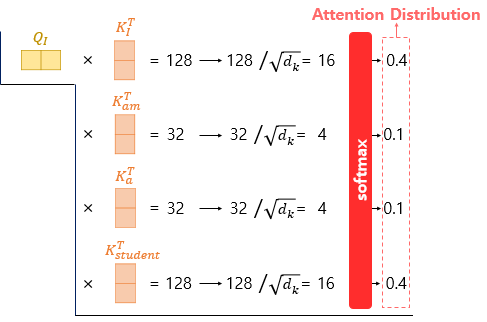

* 이제 어텐션 스코어에 소프트맥스(softmax) 함수를 사용하여 어텐션 분포(Attention Distribution)을 구한다. 
* 소프트맥스(softmax) 함수를 거친 어텐션 분포(Attention Distribution)는 전부 양수로 만들어지고 그 합은 1이 된다.
* 어텐션 분포(Attention Distribution)는 현재 위치의 단어의 인코딩에 있어서 얼마나 각 단어들의 표현이 들어갈 것인지를 결정한다.
* 당연하게 현재 위치의 단어가 가장 높은 점수를 가지며 가장 많은 부분을 차지하게 되겠지만, 가끔은 현재 단어에 관련이 있는 다른 단어에 대한 정보가 들어가는 것이 도움이 된다

### 4) Fifth, Sixth Step of Self-Attention

<img src='https://wikidocs.net/images/page/31379/transformer14_final.PNG' height="500" width="500">

* 각 V벡터와 가중합하여 어텐션 값(Attention Value)을 구한다.
* 이 단계는 관련이 있는 단어들은 남겨두고 관련이 없는 단어들은 0.001과 같은 작은 숫자(점수)를 곱해 없애버리기 위함이다.
* 마지막 여섯 번째 단계는 다섯 번째 단계를 통해 나온 값들을 다 합한다.
* 이를 단어 I에 대한 어텐션 값 또는 단어 I에 대한 컨텍스트 벡터(context vector)라고도 할 수 있다.
* 이 단계의 출력이 바로 현재 위치에 대한 Self-Attention layer의 출력이 된다.
* am에 대한 Q벡터, a에 대 Q벡터, student에 대한 Q벡터에 대해서도 모두 동일한 과정을 반복하여 각각에 대한 어텐션 값을 구한다.
* 이 결과로 나온 벡터를 FFNN layer로 보내게 된다. 

### 4.3.2 Matrix Calculation of Self-Attention

* 한 가지 의문이 드는 것은 굳이 이렇게 각 Q벡터마다 일일히 따로 연산할 필요가 있을까?

### 1) Matrix Calculation

* 사실 각 단어에 대한 Q, K, V 벡터를 구하고 스케일드 닷-프로덕트 어텐션을 수행하였던 위의 과정들은 벡터 연산이 아니라 행렬 연산을 사용하면 일괄 계산이 가능하다.
* 지금까지 벡터 연산으로 설명하였던 이유는 이해를 돕기 위한 과정이고, 실제로는 행렬 연산으로 구현된다.
* 위의 과정을 벡터가 아닌 행렬 연산으로 이해해보자.
* 우선, 각 단어 벡터마다 일일히 가중치 행렬을 곱하는 것이 아니라 문장 행렬에 가중치 행렬을 곱하여 Q행렬, K행렬, V행렬을 구한다.
* 문장 행렬은 입력 벡터들(혹은 임베딩 벡터들)을 하나의 행렬로 쌓아올린 것으로 각 행은 입력 문장의 각 단어에 해당한다.

<img src='https://wikidocs.net/images/page/31379/transformer12.PNG' height="350" width="350">

* 여기서 Q행렬을 K행렬을 전치한 행렬과 곱해준다고 해보자.
* 이렇게 되면 아래와 같이 각각의 단어의 Q벡터와 K벡터의 내적이 각 행렬의 원소가 되는 행렬이 결과로 나온다.

<img src='https://wikidocs.net/images/page/31379/transformer15.PNG' height="400" width="400">

* 다시 말해 위의 그림의 결과 행렬의 값에 전체적으로 $\sqrt{d_k}$를 나누어주면 이는 각 행과 열이 어텐션 스코어 값을 가지는 행렬이 된다.
* 예를 들어 I행과 student열의 값은 I의 Q벡터와 student의 K벡터의 어텐션 스코어 값이다.
* 이제 위 행렬을 어텐션 스코어 행렬이라고 한다.
*  어텐션 스코어 행렬을 구하였다면 남은 것은 어텐션 분포를 구하고, 이를 사용하여 모든 단어에 대한 어텐션 값을 구하는 일이다.
* 이는 간단하게 어텐션 스코어 행렬에 소프트맥스(softmax) 함수를 사용하고, V행렬을 곱하는 것으로 해결된다.
* 이렇게 되면 각 단어의 어텐션 값을 모두 가지는 어텐션 값 행렬이 결과로 나온다.

### 2) Summary of Matrix Calculation

* 행렬 연산을 통해 모든 값이 일괄 계산되는 과정을 아래와 같이 표현할 수 있다. 

<img src='https://wikidocs.net/images/page/31379/transformer16.PNG' height="500" width="500">

* 위 표현은 실제 트랜스포머 논문에 기재된 수식과 정확하게 일치하는 식이다. 

$$
Attention(Q, K, V)~ = ~softmax \Big(\frac{QK^T}{\sqrt{d_k}} \Big)V
$$

* 위 행렬 연산에 사용된 행렬의 크기를 정리해본다.
* 우선 입력 문장의 길이를 seq_len이라고 하자. 그렇다면 문장 행렬의 크기는 $(\text{seq_len}, d_{model})$이다.
* 여기에 3개의 가중치 행렬의 곱해서 Q, K, V를 만들어야 한다.
* 행렬의 크기를 정의하기 위해 행렬의 각 행에 해당되는 Q벡터와 K벡터의 차원을 $d_k$라고 하고, V벡터의 차원을 $d_v$라고 해보자.
* 그렇다면 Q행렬과 K행렬의 크기는 $(\text{seq_len}, d_k)$이며, V행렬의 크기는 $(\text{seq_len}, d_v)$가 되어야 한다.
* 그렇다면 문장 행렬과 Q, K, V 행렬의 크기로부터 가중치 행렬의 크기 추정이 가능하다.
* $W^Q$와 $W^K$는 $(d_{model}, d_k)$의 크기를 가지며, $W^V$는 $(d_{model}, d_v)$의크기를 가진다.
* 단, 논문에서는 $d_k$와 $d_v$의 차원은 $d_{model}/ \text{num_heads}$와 같다.
* 즉, $d_{model}/ \text{num_heads} = d_k = d_v$이다.
* 결과적으로 $softmax \Big(\frac{QK^T}{\sqrt{d_k}} \Big)V$식을 적용해 나오는 어텐션 값 행렬 a의 크기는 $(\text{seq_len}, d_v)$가 된다.

### 4.3.3 Multi-head Attention

* 앞서 배운 어텐션에서는 $d_{model}$의 차원을 가진 단어 벡터를 $\text{num_heads}$로 나눈 차원을 가지는 Q, K, V벡터로 바꾸고 어텐션을 수행했다.
* 문 기준으로는 512의 차원의 각 단어 벡터를 8로 나누어 64차원의 Q, K, V 벡터로 바꾸어서 어텐션을 수행한 셈이다. 
* 앞에서 작은 차원으로 계산하는 것은 단지 Multi-Head Attention의 계산 복잡도를 일정하게 만들고자 내린 구조적인 선택일 뿐이라고 했다.
* 이제 $\text{num_heads}$의 의미와 왜 $d_{model}$의 차원을 가진 단어 벡터를 가지고 어텐션을 하지 않고 축소시킨 벡터로 어텐션을 수행했는지 이해해보고자 한다.

<img src='https://wikidocs.net/images/page/31379/transformer17.PNG' height="500" width="500">

* 트랜스포머 연구진은 한 번의 어텐션을 하는 것보다 여러 번의 어텐션을 병렬로 사용하는 것이 더 효과적이라고 말한다.(얼마나 해본건지..)
* 그래서 $d_{model}$의 차원을 $\text{num_heads}$개로 나누어 $d_{model}/\text{num_heads}$ 의 차원을 가지는 Q, K, V에 대해서 $\text{num_heads}$개의 병렬 어텐션을 수행한다.
*  논문에서는 $\text{num_heads}$의 값을 8로 지정했고, 8개의 병렬 어텐션이 이루어지게 된다.
* 이때 각각의 어텐션 값 행렬을 어텐션 헤드라고 부릅니다. 
* 이때의 가중치 행렬 $W^Q, W^K, W^N$의 값은 8개의 어텐션 헤드마다 전부 다르다.

* 병렬 어텐션으로 얻을 수 있는 효과는 무엇일까?

(그리스로마신화에는 머리가 여러 개인 괴물 히드라나 케로베로스가 나온다. 이 괴물들의 특징은 머리가 여러 개이기 때문에 여러 시점에서 상대방을 볼 수 있다는 겁니다. 이렇게 되면 시각에서 놓치는 게 별로 없을테니까 이런 괴물들에게 기습을 하는 것이 굉장히 힘이 들것이다. 멀티 헤드 어텐션도 비슷하다.)
* 어텐션을 병렬로 수행하여 다른 시각으로 정보들을 수집하겠다는 것이다. 

* 예를 통해 이해해보자.
* 앞서 사용한 예문 '그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.'를 사용한다.
* 단어 그것(it)이 쿼리였다고 해보자.
* it에 대한 Q벡터로부터 다른 단어와의 연관도를 구하였을 때 첫번째 어텐션 헤드는 '그것(it)'과 '동물(animal)'의 연관도를 높게 본다면, 
* 두번째 어텐션 헤드는 '그것(it)'과 '피곤하였기 때문이다(tired)'의 연관도를 높게 볼 수 있다.
* 각 어텐션 헤드는 전부 다른 시각에서 보고있기 때문이다.

<img src='https://wikidocs.net/images/page/31379/transformer18_final.PNG' height="350" width="350">

* 병렬 어텐션을 모두 수행하였다면 모든 어텐션 헤드를 연결(concatenate)한다. 모두 연결된 어텐션 헤드 행렬의 크기는 $(\text{seq_len}, d_{model})$이 된다.

<img src='https://wikidocs.net/images/page/31379/transformer19.PNG' height="500" width="500">

* 어텐션 헤드를 모두 연결한 행렬은 또 다른 가중치 행렬 $W^o$를 곱하게 되는데, 이렇게 나온 결과 행렬이 멀티-헤드 어텐션의 최종 결과물이다. 
* 위의 그림은 어텐션 헤드를 모두 연결한 행렬이 가중치 행렬 $W^o$과 곱해지는 과정을 보여준다.
* 이때 결과물인 멀티-헤드 어텐션 행렬은 인코더의 입력이었던 문장 행렬의 $(\text{seq_len}, d_{model})$크기와 동일하다.
* 다시 말해 인코더의 첫번째 서브층인  Multi-Head Attention 단계를 끝마쳤을 때, 인코더의 입력으로 들어왔던 행렬의 크기가 유지되고 있다는 의미이다.
* 첫번째 서브층인 Multi-Head Attention과 두번째 서브층인 FFNN layer를 지나면서 인코더의 입력으로 들어올 때의 행렬의 크기는 계속 유지되어야 한다.
* 트랜스포머는 동일한 구조의 인코더를 쌓은 구조이기 때문에 인코더에서의 입력의 크기가 출력에서도 동일 크기로 계속 유지되어야만 다음 인코더에서도 다시 입력이 될 수 있다.

### 4.3.4 Padding Mask 🌟

* **마스킹(Masking)**이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다.
* Padding Mask는 패딩 토큰(Padding token)을 이용한 방법이다.
* 사실 단어 `<PAD>`의 경우에는 실질적인 의미를 가진 단어가 아니다.
* 그래서 입력 문장에 `<PAD>` 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산을 진행한다. 
* 트랜스포머에서는 Key의 경우에 `<PAD>` 토큰이 존재한다면 이에 대해서는 유사도를 구하지 않도록 마스킹(Masking)을 한다.
* 여기서 마스킹이란 어텐션에서 제외하기 위해 값을 가린다는 의미이다. 
* 예를 들어 `<PAD>`가 포함된 입력 문장의 셀프 어텐션의 예제를 보자. 이에 대해서 어텐션을 수행하고 어텐션 스코어 행렬을 얻는 과정은 다음과 같다.

<img src='https://wikidocs.net/images/page/31379/pad_masking11.PNG' height="450" width="450">

* 어텐션 스코어 행렬에서 행에 해당하는 문장은 Query이고, 열에 해당하는 문장은 Key입니다. 그리고 Key에 `<PAD>`가 있는 경우에는 해당 열 전체를 마스킹을 해준다.

<img src='https://wikidocs.net/images/page/31379/pad_masking2.PNG' height="350" width="350">

* 마스킹을 하는 방법은 어텐션 스코어 행렬의 마스킹 위치에 매우 작은 음수값을 넣어주는 것이다.
* 여기서 매우 작은 음수값이라는 것은 -1,000,000,000과 같은 -무한대에 가까운 수라는 의미이다. 
* 현재 어텐션 스코어 함수는 소프트맥스 함수를 지나지 않은 상태이다.
* 이 어텐션 스코어 함수는 소프트맥스 함수를 지나고, 그 후 Value 행렬과 곱해지게 된다.
* 그런데 현재 마스킹 위치에 매우 작은 음수 값이 들어가 있으므로 어텐션 스코어 행렬이 소프트맥스 함수를 지난 후에는 해당 위치의 값은 0이 되어 단어 간 유사도를 구하는 일에 `<PAD`> 토큰이 반영되지 않게 된다.

<img src='https://wikidocs.net/images/page/31379/softmax.PNG' height="250" width="250">

* 위 그림은 소프트맥스 함수를 지난 후를 가정하고 있다. 
* 소프트맥스 함수를 지나면 각 행의 어텐션 가중치의 총 합은 1이 되는데, 단어 `<PAD>`의 경우에는 0이 되어 어떤 유의미한 값을 가지고 있지 않다. 

### 4.4 Position-wise FFNN 🌟

* 지금은 인코더를 설명하고 있지만, Position-wise FFNN은 인코더와 디코더에서 공통적으로 가지고 있는 서브층이다. 
* Position-wise FFNN는 쉽게 말하면 완전 연결 FFNN(Fully-connected FFNN)이라고 해석할 수 있다. 
* 앞서 인공 신경망은 결국 벡터와 행렬 연산으로 표현될 수 있음을 확인했다. 아래는 포지션 와이즈 FFNN의 수식을 보여준다.

$$
FFNN(x) = MAX(0, xW_1 + b_1)W_2 + b_2
$$

* 식을 그림으로 표현하면 아래와 같다.

<img src='https://wikidocs.net/images/page/31379/positionwiseffnn.PNG' height="200" width="200">

* 여기서 $x$는 앞서 멀티 헤드 어텐션의 결과로 나온 $(\text{seq_len}, d_{model})$의 크기를 가지는 행렬을 말한다.
* 가중치 행렬 $W_1$ 은 $(d_{model}, d_{ff})$의 크기를 가지고, 가중치 행렬 $W_2$는 $(d_{ff}, d_{model})$의 크기를 가진다.
* 논문에서 은닉층의 크기인 $d_{ff}$는 앞서 하이퍼파라미터를 정의할 떄 언급했듯이 2,048의크기를 가진다.

* 여기서 매개변수 $W_1, b_1, W_2, b_2$는 하나의 인코더 층 내에서는 다른 문장, 다른 단어들마다 정확하게 동일하게 사용된다.
* 하지만 인코더 층마다는 다른 값을 가진다.

<img src='https://wikidocs.net/images/page/31379/transformer20.PNG' height="500" width="500">

* 위의 그림에서 좌측은 인코더의 입력을 벡터 단위로 봤을 때, 각 벡터들이 Multi-Head Attention layer이라는 인코더 내 첫번째 sub-layer를 지나 FFNN을 통과하는 것을 보여준다.
* 이는 두번째 sub-layer인 Position-wise FFNN을 의미한다.
* 물론, 실제로는 그림의 우측과 같이 행렬로 연산되는데, 두번째 서브층을 지난 인코더의 최종 출력은 여전히 인코더의 입력의 크기였던 $(\text{seq_len}, d_{model})$의 크기가 보존된다.
* 하나의 인코더 층을 지난 이 행렬은 다음 인코더 층으로 전달되고, 다음 층에서도 동일한 인코더 연산이 반복된다.

### 4.5 Residual connection and Layer Normalization 🌟

* 트랜스포머에서는 두 개의 usb-layer를 가진 인코더에 추가적으로 사용하는 기법이 있는데, 바로 Add & Norm이다.
* 더 정확히는 Residual connection(잔차 연결)과 Layer Normalization(층 정규화)를 의미한다.

<img src='https://wikidocs.net/images/page/31379/transformer21.PNG' height="450" width="450">

* 위의 그림은 앞서 Position-wise FFNN를 설명할 때 사용한 그림에서 화살표와 Add & Norm(잔차 연결과 정규화 과정)을 추가한 그림이다.
* 추가된 화살표들은 서브층 이전의 입력에서 시작되어 서브층의 출력 부분을 향하고 있다. 

### 4.5.1 Residual connection

* Residual connection(잔차 연결)의 의미를 이해하기 위해서 어떤 함수를 $H(x)$를 살펴보자.

<img src='https://wikidocs.net/images/page/31379/transformer22.PNG' height="180" width="180">

* 위 그림은 입력 $x$와 $x$에 대한 어떤 함수 $F(x)$의 값을 더한 함수 $H(x)$의 구조를 보여준다.
* 어떤 함수 $F(x)$가 트랜스포머에서는 sub-layer에 해당한다.
* 다시 말해 Residual connection(잔차 연결)은 서브층의 입력과 출력을 더하는 것을 말한다.
* 앞서 언급했듯이 트랜스포머에서 sub-layer의 입력과 출력은 동일한 차원을 갖고 있으므로, sub-layer의 입력과 sub-layer의 출력은 덧셈 연산을 할 수 있다.
* 이것이 바로 위의 인코더 그림에서 각 화살표가 sub-layer의 입력에서 출력으로 향하도록 그려졌던 이유이다. 
* 이를 식으로 표현하면 $x+\text{Sublayer}(x)$이다. 
* 가령, sub-layer가 Multi-Head Attention이었다면 Residual connection(잔차 연결) 연산은 다음과 같다.

$$
H(x) = x + \text{Multi} - \text{head Attention}(x)
$$

* 아래 그림은 Multi-Head Attention의 입력과 Multi-Head Attention의 결과가 더해지는 과정을 보여준다.

<img src='https://wikidocs.net/images/page/31379/residual_connection.PNG' height="550" width="550">

### 4.5.2 Layer Normalization

* Residual connection(잔차 연결)을 거친 결과는 이어서 Layer Normalization(층 정규화) 과정을 거치게 된다.
* Residual connection(잔차 연결)의 입력을 $x$, Residual connection(잔차 연결)과 Layer Normalization(층 정규화) 두 가지 연산을 모두 수행한 후의 결과 행렬을 $LN$이라고 하였을 때, Residual connection(잔차 연결) 후 Layer Normalization(층 정규화) 연산을 수식으로 표현하자면 다음과 같다.

$$
Ln = \text{Layer Norm}(x+\text{Sublayer}(x))
$$

* Layer Normalization(층 정규화)는 텐서의 마지막 차원에 대해서 평균과 분산을 구하고, 이를 가지고 어떤 수식을 통해 값을 정규화하여 학습을 돕는다.
* 여기서 텐서의 마지막 차원이란 것은 트랜스포머에서는 $d_{model}$ 차원을 의미한다.
* 아래 그림은 $d_{model}$ 차원의 방향을 화살표로 표현했다.

<img src='https://wikidocs.net/images/page/31379/layer_norm_new_1_final.PNG' height="250" width="250">

* 층 정규화를 위해서 우선, 화살표 방향으로 각각 평균$\mu$과 분산$\sigma^2$을 구한다. 
* 각 화살표 방향의 벡터를 $x_i$라고 명명한다.

<img src='https://wikidocs.net/images/page/31379/layer_norm_new_2_final.PNG' height="250" width="250">

* 층 정규화를 수행한 후에는 벡터 $x_i$는 $ln_i$라는 벡터로 정규화가 된다.

$$
ln_i = \text{LayerNorm}(x_i)
$$

* Layer Normalization(층 정규화)의 수식을 알아보자.
* 여기서는 Layer Normalization(층 정규화)를 두 가지 과정으로 나누어서 설명한다.
* 첫번째는 평균과 분산을 통한 정규화, 두번째는 감마와 베타를 도입하는 것이다. 
* 우선, 평균과 분산을 통해 벡터 $x_i$를 정규화 해준다. $x_i$는 벡터인 반면, 평균$\mu_i$과 분산 $\sigma_i^2$은 스칼라이다. 
* 벡터 $x_i$의 각 차원을 $k$라고 하였을 때, $x_{i,k}$는 다음의 수식과 같이 정규화 할 수 있다. 
* 다시 말해 벡터 $x_i$의 각 $k$차원의 값이 다음과 같이 정규화 되는 것이다.

$$
\hat{x}_{i,k} = \frac{x_{i,k}-\mu_i}{\sqrt{(\sigma_i^2+\epsilon)}}
$$

* $\epsilon$은 분모가 0이 되는 것을 방지하는 값이다.

* 이제 $\gamma$(감마)와 $\beta$(베타)라는 벡터를 준비한다. 단, 이들의 초기값은 각각 1과 0이다.

<img src='https://wikidocs.net/images/page/31379/%EA%B0%90%EB%A7%88%EB%B2%A0%ED%83%80.PNG' height="200" width="200">

* $\gamma$와 $\beta$를 도입한 Layer Normalization(층 정규화)의 최종 수식은 다음과 같으며 $\gamma$와 $\beta$는 학습 가능한 파라미터이다.

$$
ln_i = \gamma\hat{x}_i+\beta = \text{LayerNorm}(x_i)
$$

* 케라스에서는 Layer Normalization(층 정규화)를 위한 LayerNormalization()를 제공하고 있으므로 이를 가져와 사용한다.

### 4.6 From Encoder To Decoder

<img src='https://wikidocs.net/images/page/31379/transformer_from_encoder_to_decoder.PNG' height="450" width="450">

* 이렇게 구현된 인코더는 총 $\text{num_layers}$만큼의 층 연산을 순차적으로 한 후에 마지막 층의 인코더의 출력을 디코더에게 전달한다.
* 인코더 연산이 끝났으면 디코더 연산이 시작되어 디코더 또한 $\text{num_layers}$만큼의 연산을 하는데, 이때마다 인코더가 보낸 출력을 각 디코더 층 연산에 사용한다.

### 4.7 Decoder First Sub-Layer : Self-Attention and Look Ahead Mask

<img src='https://wikidocs.net/images/page/31379/decoder.PNG' height="250" width="250">

* 위 그림과 같이 디코더도 인코더와 동일하게 임베딩 층과 포지셔널 인코딩을 거친 후의 문장 행렬이 입력된다. 
* 트랜스포머 또한 seq2seq와 마찬가지로 교사 강요(Teacher Forcing)을 사용하여 훈련되므로 학습 과정에서 디코더는 번역할 문장에 해당되는 `<sos>` je suis étudiant의 문장 행렬을 한 번에 입력받는다. 
* 디코더는 이 문장 행렬로부터 각 시점의 단어를 예측하도록 훈련된다.
* 여기서 문제가 발생한다.
* seq2seq의 디코더에 사용되는 RNN 계열의 신경망은 입력 단어를 매 시점마다 순차적으로 입력받으므로 다음 단어 예측에 현재 시점을 포함한 이전 시점에 입력된 단어들만 참고할 수 있다. 
* 반면, 트랜스포머는 문장 행렬로 입력을 한 번에 받으므로 현재 시점의 단어를 예측하고자 할 때, 입력 문장 행렬로부터 미래 시점의 단어까지도 참고할 수 있는 현상이 발생한다. 
* 가령, suis를 예측해야 하는 시점이라고 해보자.
* RNN 계열의 seq2seq의 디코더라면 현재까지 디코더에 입력된 단어는 `<sos>`와 je뿐일 것이다. 
* 반면, 트랜스포머는 이미 문장 행렬로 `<sos>` je suis étudiant를 입력았다. 
* 이를 위해 트랜스포머의 디코더에서는 현재 시점의 예측에서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 Look-Ahead Mask(룩-어헤드 마스크)를 도입했다. 

<img src='https://wikidocs.net/images/page/31379/%EB%94%94%EC%BD%94%EB%8D%94.PNG' height="250" width="250">

* Look-Ahead Mask(룩-어헤드 마스크)는 디코더의 첫번째 서브층에서 이루어진다. 
* 디코더의 첫번째 sub-layer인 Multi-Head Self-Attention layer는 인코더의 첫번째 sub-layer인 Multi-Head Self-Attention layer와 동일한 연산을 수행한다.
* 오직 다른 점은 어텐션 스코어 행렬에서 마스킹을 적용한다는 점만 다르다. 
* 우선 다음과 같이 셀프 어텐션을 통해 어텐션 스코어 행렬을 얻는다.

<img src='https://wikidocs.net/images/page/31379/decoder_attention_score_matrix.PNG' height="450" width="450">

* 이제 자기 자신보다 미래에 있는 단어들은 참고하지 못하도록 다음과 같이 마스킹한다.

<img src='https://wikidocs.net/images/page/31379/%EB%A3%A9%EC%96%B4%ED%97%A4%EB%93%9C%EB%A7%88%EC%8A%A4%ED%81%AC.PNG' height="250" width="250">

* 마스킹 된 후의 어텐션 스코어 행렬의 각 행을 보면 자기 자신과 그 이전 단어들만을 참고할 수 있음을 볼 수 있다. 
* 그 외에는 근본적으로 Self-Attention이라는 점과, Multi-Head Attention을 수행한다는 점에서 인코더의 첫번째 sub-layer와 같다.

### 4.8 Decoder Second Sub-Layer : Encoder-Decoder Attention

* 디코더의 두 번째 sub-layer에 대해서 이해해보자.
* 디코더의 두 번째 sub-layer는  Multi-Head Attention을 수행한다는 점에서는 이전의 어텐션들(인코더와 디코더의 첫 번째 sub-layer)과는 공통점이 있으나 이번에는 Self-Attention이 아니다.
* Self-Attention은 Query, Key, Value가 같은 경우를 말하는데, Encoder-Decoder Attention은 Query가 디코더인 행렬인 반면, Key와 Value는 인코더 행렬이기 때문이다.
```
인코더의 첫번째 서브층 : Query = Key = Value
디코더의 첫번째 서브층 : Query = Key = Value
디코더의 두번째 서브층 : Query : 디코더 행렬 / Key = Value : 인코더 행렬
```
* 디코더의 두 번째 sub-layer를 확대해보면, 다음과 같이 인코더로부터 두 개의 화살표가 그려져 있다.

<img src='https://wikidocs.net/images/page/31379/%EB%94%94%EC%BD%94%EB%8D%94%EB%91%90%EB%B2%88%EC%A7%B8%EC%84%9C%EB%B8%8C%EC%B8%B5.PNG' height="150" width="150">

* 두 개의 화살표는 각각 Key와 Value를 의미하며 이는 인코더의 마지막 층에서 온 행렬로부터 얻는다. 
* 반면 Query는 디코더의 첫 번째 sub-layer의 결과 행렬로부터 얻는다는 점이 다르다. 
* Query가 디코더 행렬, Key가 인코더 행렬일 때, 어텐션 스코어 행렬을 구하는 과정은 다음과 같다.

<img src='https://wikidocs.net/images/page/31379/%EB%94%94%EC%BD%94%EB%8D%94%EB%91%90%EB%B2%88%EC%A7%B8%EC%84%9C%EB%B8%8C%EC%B8%B5%EC%9D%98%EC%96%B4%ED%85%90%EC%85%98%EC%8A%A4%EC%BD%94%EC%96%B4%ED%96%89%EB%A0%AC_final.PNG' height="450" width="450">

* 그 외에 Multi-Head Attention을 수행하는 과정은 다른 어텐션들과 같다.

### 4.9 The Decoder Side

* 이제 이 부분들이 모여서 어떻게 같이 작동하는지 보자. 
* 인코더가 먼저 입력 시퀀스를 처리하기 시작한다. 
* 그 다음 가장 윗단의 인코더의 출력은 attention 벡터들인 K와 V로 변형된다. 
* 이 벡터들은 이제 각 디코더의 "encoder-decoder attention" layer에서 디코더가 입력 시퀀스에서 적절한 장소에 집중할 수 있도록 도와준다.

<img src='https://nlpinkorean.github.io/images/transformer/transformer_decoding_1.gif' height="600" width="600">

* 이 인코딩 단계가 끝나면 이제 디코딩 단계가 시작된다. 
* 디코딩 단계의 각 스텝은 출력 시퀀스의 한 요소를 출력한다. 
* 디코딩 스텝은 디코더가 출력을 완료했다는 기호인 `<end of sentence>`를 출력할 때까지 반복된다. 
* 각 스텝마다의 출력된 단어는 다음 스텝의 가장 밑단의 디코더에 들어가고 인코더와 마찬가지로 여러 개의 디코더를 거쳐 올라간다. 
* 인코더의 입력에 했던 것과 동일하게 임베딩을 한 후 Positional Encoding을 추가하여 디코에게 각 단어의 위치 정보를 더해준다.

<img src='https://nlpinkorean.github.io/images/transformer/transformer_decoding_2.gif' height="600" width="600">

* 디코더 내에 있는 Self-Attention layer들은 인코더와는 조금 다르게 작동한다.
* 디코더에서의 Self-Attention layer는 output sequence 내에서 현재 위치의 이전 위치들에 대해서만 attend 할 수 있다. 
* 이것은 Self-Attention 계산 과정에서 소프트맥스(softmax) 함수를 취하기 전에 현재 스텝 이후의 위치들에 대해서 masking을 해줌으로써 가능해진다.
* "Encoder-Decoder Attention" layer는 Multi-Head Self-Attention과 한 가지를 제외하고는 똑같은 방법으로 작동하는데, 그 한 가지 차이점은 Query 행렬들을 그 밑의 layer에서 가져오고 Key 와 Value 행렬들을 인코더의 출력에서 가져온다는 점이다.

### 4.10 The Final Linear and Softmax Layer

* 여러 개의 디코더를 거치고 난 후에는 실수로 이루어진 벡터 하나가 남게 된다. 
* 어떻게 이 하나의 벡터를 단어로 바꿀 수 있을까? 
* 이것이 바로 마지막에 있는 Linear layer와 소프트맥스(Softmax) 함수가 하는 일이다.
 
* Linear layer은 fully-connected 신경망으로 디코더가 마지막으로 출력한 벡터를 그보다 훨씬 더 큰 사이즈의 벡터인 logits 벡터로 투영시킨다.
* 모델이 training 데이터에서 총 10,000개의 영어 단어를 학습하였다고 가정해본다. (이를 모델의 “output vocabulary”라고 부른다.) 
* 그렇다면 이 경우에 logits vector의 크기는 10,000이 될 것이다. – 벡터의 각 셀은 그에 대응하는 각 단어에 대한 점수가 된다. 
* 이렇게 되면 우리는 Linear layer의 결과로서 나오는 출력에 대해서 해석을 할 수 있게 된다.
 
* 그다음에 나오는 소프트맥스(Softmax) 함수는 이 점수들을 확률로 변환해주는 역할을 한다. 
* 셀들의 변환된 확률 값들은 모두 양수 값을 가지며 다 더하게 되면 1이 된다. 
* 가장 높은 확률 값을 가지는 셀에 해당하는 단어가 해당 스텝의 최종 결과물로서 출력되게 된다.

<img src='https://nlpinkorean.github.io/images/transformer/transformer_decoder_output_softmax.png' height="550" width="550">

### 5. Recap Of Training

### 5.1 Encoding

* 학습 과정을 시각화하기 위해, output vocabulary가 6개의 단어만 (("a", "am", "i", "thanks", "student", and "`<eos>`" ('end of sentence'의 줄임말))) 포함하고 있다고 가정한다.

<img src='https://nlpinkorean.github.io/images/transformer/vocabulary.png' height="650" width="650">

* 모델의 output vocabulary는 학습을 시작하기 전인 preprocessing 단계에서 완성된다. 
* 이 output vocabulary를 정의한 후에는, 이 vocabulary의 크기만한 벡터를 이용하여 각 단어를 표현할 수 있다. 
* 이것은 one-hot encoding이라고도 불린다. 그러므로 위 예제에서는, 단어 "am" 을 다음과 같은 벡터로 나타낼 수 있다.

<img src='https://nlpinkorean.github.io/images/transformer/one-hot-vocabulary-example.png' height="650" width="650">

### 5.2 Loss Function

* 모델을 학습하는 상황에서 가장 첫 번째 단계라고 가정한다. 
* 그리고 "merci"라는 불어를 "thanks"로 번역하는 학습을 간단한 예시로 보자. 
* 이 말은 우리가 원하는 모델의 출력이 "thanks"라는 단어를 가리키는 확률 벡터란 것이다. 
* 하지만 현재의 모델은 아직 학습이 되지 않았기 때문에 출력이 "thanks"로 나올 확률은 매우 작다.

<img src='https://nlpinkorean.github.io/images/transformer/transformer_logits_output_and_label.png' height="650" width="650">

* 학습이 시작될 때 모델의 parameter들. 즉, weight들은 랜덤으로 값을 부여하기 때문에 아직 학습이 되지 않은 모델은 그저 각 cell (word)에 대해서 임의의 값을 출력한다. 
* 이 출력된 임의의 값을 가지는 벡터와 데이터 내의 실제 출력값을 비교하여, 그 차이와 backpropagation 알고리즘을 이용해 현재 모델의 weight들을 조절해 원하는 출력값에 더 가까운 출력이 나오도록 만든다.
* 두 확률 벡터의 비교는 하나의 벡터에서 다른 하나의 벡터를 빼버리는 것으로 진행된다. 
  * 참고 : [Cross-Entropy](https://colah.github.io/posts/2015-09-Visual-Information/)
  * 참고 : [Kullback–Leibler divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained)
* 하지만 여기서 하나 주의할 것은 우리가 고려하고 있는 예제가 지나치게 단순화된 경우란 것이다. 
* 조금 더 현실적인 예제에서는 한 단어보다는 긴 문장을 이용할 것이다. 
* 예를 들어 입력은 불어 문장 "je suis étudiant"이며 바라는 출력은 "i am a student"일 것이다. 
* 이 말은 모델이 출력할 확률 분포에 대해서 우리가 바라는 것은 다음과 같다.
  * 각 단어에 대한 확률 분포는 output vocabulary 크기를 가지는 벡터에 의해서 나타내진다. (우리의 간단한 예제에서는 6이지만 실제 실험에서는 3,000 혹은 10,000과 같은 숫자일 것이다.)
  * 디코더가 첫 번째로 출력하는 확률 분포는 "i"라는 단어와 연관이 있는 cell에 가장 높은 확률을 줘야 한다.
  * 두 번째로 출력하는 확률 분포는 "am"라는 단어와 연관이 있는 cell에 가장 높은 확률을 줘야 한다.
  * 이와 동일하게 마지막 `'<end of sentence>'`를 나타내는 다섯 번째 출력까지 이 과정은 반복된다. (`'<eos>'` 또한 그에 해당하는 cell을 벡터에서 가진다.)

<img src='https://nlpinkorean.github.io/images/transformer/output_target_probability_distributions.png' height="650" width="650">

* 위의 그림은 학습에서 목표로 하는 확률 분포를 나타낸 것이다. 
* 모델을 큰 사이즈의 데이터 셋에서 충분히 학습을 시키고 나면, 그 결과로 생성되는 확률 분포들은 아래와 같아질 것이다.

<img src='https://nlpinkorean.github.io/images/transformer/output_trained_model_probability_distributions.png' height="650" width="650">

* 여기서 한 가지 특이한 점은 모델의 출력값 중 다른 단어(목표하는 단어를 제외한 나머지 단어)들이 최종 출력이 될 가능성이 거의 없다 해도 모든 단어가 0보다는 조금씩 더 큰 확률을 가진다는 점이다.
* 이것은 학습 과정을 도와주는 소프트맥스(Softmax) 함수의 유용한 성질이다.

### 6. Import Libraries

In [1]:
import re
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### 7. Transformer Implementation

### 7.1 Positional Encoding

* Positional Encoding을 사용하면 단어의 순서 정보가 보존된다. 
* 임베딩 벡터에 Positional Encoding의 값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의 입력으로 들어가는 임베딩 벡터의 값이 달라진다.
* 이에 따라 트랜스포머의 입력은 순서 정보가 고려된 임베딩 벡터가 된다.

$$
PE_{(pos, 2i)}  =  sin(pos/10000^{2i/d_{model}}) \\
PE_{(pos, 2i+1)}  =  cos(pos/10000^{2i/d_{model}})
$$

<img src='https://d3s0tskafalll9.cloudfront.net/media/images/Untitled_9_l58gVWT.max-800x600.png' height="250" width="250">

In [2]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    # 각도 배열 생성
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스(2i)에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스(2i+1)에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

* 50 × 128의 크기를 가지는 Positional Encoding을 시각화하여  어떤 형태를 가지는지 확인한다.
* 이는 입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬이다.

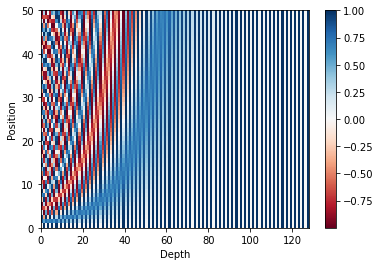

In [3]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 7.2 Scaled dot-product Attention + Mask

* Q행렬과 K행렬을 전치한 행렬을 곱하고, 소프트맥스 함수를 사용하여 어텐션 분포 행렬을 얻은 뒤에 V행렬과 곱한다.

<img src='https://paul-hyun.github.io/assets/2019-12-19/scale_dot_product_attention.png' height="300" width="300">

$$
\text{Attention}(Q, K, V) = \text{softmax} \Big(\frac{QK^T}{\sqrt d_k} \Big)V
$$

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : 최종 어텐션은 가중치와 V의 닷 프로덕트 (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

### 7.3 Multi-head Attention

* Multi-head Attention에서는 크게 두 종류의 가중치 행렬이 나왔다.
* Q, K, V 행렬을 만들기 위한 가중치 행렬인 $W^Q$, $W^K$, $W^V$ 행렬과 바로 어텐션 헤드들을 연결(concatenation) 후에 곱해주는 $W^O$ 행렬이다.
* 가중치 행렬을 곱하는 것을 구현 상에서는 입력을 전결합층. 즉, 밀집층(Dense layer)을 지나게 하여 구현한다.
* Multi-head Attention의 구현은 크게 다섯 가지 파트로 구성된다.
  * $W^Q$, $W^K$, $W^V$에 해당하는 $\text{d_model}$ 크기의 밀집층(Dense layer)을 지나게 한다.
  * 지정된 헤드 수($\text{num_heads}$)만큼 나눈다(split).
  * Scaled dot-product Attention
  * 나눠졌던 헤드들을 연결(concatenatetion)한다.
  * $W^O$에 해당하는 밀집층을 지나게 한다.

<img src='https://paul-hyun.github.io/assets/2019-12-19/multi_head_attention.png' height="380" width="380">

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기(병렬 연산을 위한 머리를 여러 개 만들기)
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

### 7.4 Mask

* 트랜스포머에는 총 세 가지 어텐션이 존재하며, 모두 Multi-Head Attention을 수행하고, Multi-Head Attention함수 내부에서 Scaled dot-product Attention 함수를 호출하는데 각 어텐션 시 함수에 전달하는 마스킹은 다음과 같다.
  * 인코더의 Self-Attention : Padding Mask 전달
  * 디코더의 첫번째 서브층인 Masked Self-Attention : Look-Ahead Mask 전달
  * 디코더의 두번째 서브층인 Encoder-Decoder Attention : Padding Mask 전달
* 이때 Look-Ahead Mask를 한다고해서 Padding Mask가 불필요한 것이 아니므로 Look-Ahead Mask는 Padding Mask를 포함하도록 구현한다.

### 7.4.1 Padding Mask

* 패딩 마스크를 구현하는 방법은 입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것이다. 
* 아래의 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수이다.
* 아래 함수를 통해 반환되는 벡터를 통해서 1의 값을 가진 위치의 열을 어텐션 스코어 행렬에서 마스킹하는 용도로 사용할 수 있다.
* 아래 함수를 통해 반환되는 벡터를 Scaled dot-product Attention의 인자로 전달하면, 해당 벡터에다가 매우 작은 음수값인 -1e9를 곱하고, 이를 행렬에 더해주어 해당 열을 전부 마스킹한다.

In [6]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

### 7.4.2 Look-Ahead Mask

* 순환 신경망, RNN과 트랜스포머는 문장을 입력받을 때 입력받는 방법이 전혀 다르다.
* 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다.
* 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다. 
* 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이다. 
* 따라서 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법인 Look-ahead masking을 사용한다.
* 패딩 마스크와 마찬가지로 앞서 구현한 Scaled dot-product Attention 함수에 mask라는 인자로 전달한다.
* Look-Ahead Mask를 구현하는 방법은 패딩 마스크 때와 마찬가지로 마스킹을 하고자 하는 위치에는 1을, 마스킹을 하지 않는 위치에는 0을 리턴하도록 한다.

In [7]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)

### 7.5 Position-wise FFNN

* Position-wise FFNN은 인코더와 디코더에서 공통적으로 가지고 있는 sub-layer이다.

<img src='https://paul-hyun.github.io/assets/2019-12-19/feed-forward.png' height="400" width="400">

<img src='https://wikidocs.net/images/page/31379/transformer20.PNG' height="400" width="400">

```python
# Position-wise FFNN을 구현하면 아래와 같다
# 다음의 코드는 인코더와 디코더 내부에서 사용할 예정이다.
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outputs = tf.keras.layers.Dense(units=d_model)(outputs)
```

### 7.6 Encoder

* 인코더의 입력으로 들어가는 문장에는 패딩이 있을 수 있으므로, 어텐션 시 패딩 토큰을 제외하도록 패딩 마스크를 사용한다.
*  이는 Multi-Head Attention 함수의 mask의 인자값으로 Padding Mask가 사용되는 이유이다. 
* 인코더는 총 두 개의 sub-layer로 이루어지는데, Multi-Head Attention과 FFNN이다.
* 각 서브층 이후에는 드롭 아웃, 잔차 연결과 층 정규화가 수행된다.

<img src='https://paul-hyun.github.io/assets/2019-12-19/encoder.png' height="150" width="150">

In [8]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': padding_mask # 패딩 마스크 사용
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

* 인코더 층을 num_layers개만큼 쌓고, 마지막 인코더 층에서 얻는 $(\text{seq_len}, d_{model})$ 크기의 행렬을 디코더로 보내줌으로써 트랜스포머 인코더의 인코딩 연산이 끝나게 된다.

In [9]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):

    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 7.7 Decoder

* 디코더는 총 세 개의 sub-layer로 구성된다.
* 첫 번째와 두 번째 sub-layer 모두 Multi-Head Attention이지만, 첫 번째 sub-layer는 mask의 인자값으로 Look-Ahead Mask가 들어가고
* 두 번째 sub-layer는 mask의 인자값으로 Padding Mask가 들어간다.
* 이는 첫 번째 sub-layer는 Masked Self-Attention을 수행하기 때문이다.
* 세 개의 sub-layer 모두 sub-layer 연산 후에는 드롭 아웃, 잔차 연결, 층 정규화가 수행된다.

<img src='https://paul-hyun.github.io/assets/2019-12-19/decoder.png' height="150" width="150">

In [10]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
            'mask': look_ahead_mask # 룩어헤드 마스크
        })

    # 잔차 연결과 층 정규화
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
            'mask': padding_mask # 패딩 마스크
        })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

* Positional Encoding 후 디코더 층을 num_layers의 개수만큼 쌓는다.

In [11]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 7.8 Transformer

* 지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립한다.
* 인코더의 출력은 디코더에서 Encoder-Decoder Attention에서 사용되기 위해 디코더로 전달해준다.
* 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 출력층을 추가한다.

In [12]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
        d_model=d_model, num_heads=num_heads, dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

* Transformer 모델의 구조를 그림으로 살펴보자

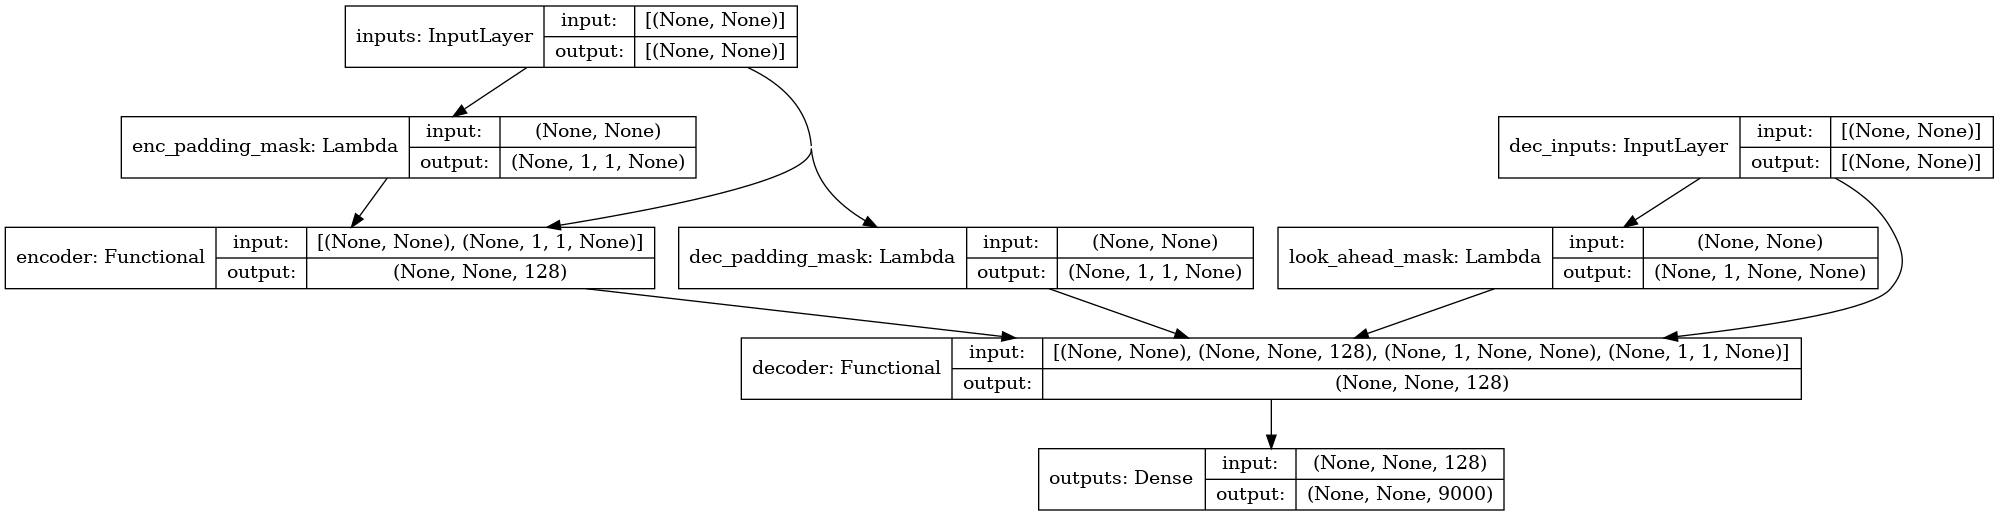

In [13]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,  # 인코더와 디코더의 층의 개수
    dff = 512,       # 피드 포워드 신경망의 은닉층의 크기
    d_model = 128,   # 인코더와 디코더 내부의 입, 출력의 고정 차원
    num_heads = 4,   # 멀티 헤드 어텐션에서의 헤드 수
    dropout = 0.3,   # 드롭아웃의 비율
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

### 7.9 Loss Function

* chatbot은 다중 클래스 분류 문제이므로 크로스 엔트로피 함수를 손실 함수로 정의한다.

In [14]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 7.10 Learning Rate Scheduler

* Learning rate Scheduler는 미리 학습 일정을 정해두고 그 일정에 따라 학습률이 조정되는 방법이다. 
* 트랜스포머의 경우 사용자가 정한 단계까지는 학습률을 증가시켰다가 단계에 이르면 학습률을 점차적으로 떨어트리는 방식을 사용한다.
  * $\text{step_num}$ : 옵티마이저가 매개변수를 업데이트 하는 한 번의 진행 횟수
  * 트랜스포머에서는 $\text{warmup_steps}$라는 변수를 정하고 $\text{step_num}$이 $\text{warmup_steps}$보다 작을 경우는 학습률을 선형적으로 증가
  * $\text{step_num}$이 $\text{warmup_steps}$에 도달하게 되면 학습률을 $\text{step_num}$의 역제곱근에 따라서 감소시킨다.
* 이를 식으로 표현하면 아래와 같다.

$$
\text{lrate} = d_{model}^{-0.5} \times \text{min}(\text{step_num}^{-0.5}, \text{step_num} \times \text{warmup_steps}^{-1.5})
$$

In [15]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

* 학습률의 변화를 시각화 해본다.

Text(0.5, 0, 'Train Step')

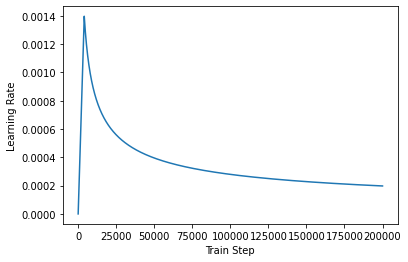

In [16]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 8. Make Chatbot

### 8.1 Load Data

In [17]:
train_data = pd.read_csv('~/aiffel/transformer_chatbot/data/ChatbotData .csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


* 이 데이터는 질문과 대답의 쌍으로 이루어진 데이터이다.

In [18]:
print('The number of charbot sample :', len(train_data))

The number of charbot sample : 11823


* 총 11,823개의 샘플이 있다. 

In [19]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


* Null값을 별도로 존재하지 않는다.

### 8.2 Data Preprocessing

In [20]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

* 원 데이터에서 ?, ., !와 같은 구두점을 미리 처리해야 한다. 
* 구두점들을 단순히 제거할 수도 있겠지만, 여기서는 구두점 앞에 공백을 추가해 다른 문자들과 구분한다.

In [21]:
answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [22]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [23]:
len(questions)

11823

In [24]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


### 8.3 Create Vocabulary

* TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.
* 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩한다.

In [25]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [26]:
print('START_TOKEN Number :',START_TOKEN)
print('END_TOKEN Number :',END_TOKEN)
print('Size of VOCAB :',VOCAB_SIZE)

START_TOKEN Number : [8178]
END_TOKEN Number : [8179]
Size of VOCAB : 8180


### 8.4 Integer Encoding and Padding

In [27]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [28]:
# 서브워드텍스트인코더 토크나이저의 encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized String {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('Original String: {}'.format(original_string))

Tokenized String [5766, 611, 3509, 141, 685, 3747, 849]
Original String: 가스비 비싼데 감기 걸리겠어


In [29]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


* 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 `START_TOKEN` 및 `END_TOKEN`을 추가한다.
* 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
* MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.

In [30]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
  
    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [31]:
questions, answers = tokenize_and_filter(questions, answers)

In [32]:
print('Questions Data Shape :', questions.shape)
print('Answers Data Shape :', answers.shape)

Questions Data Shape : (11823, 40)
Answers Data Shape : (11823, 40)


In [33]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [34]:
print('Vocab size(단어 집합의 크기): {}'.format(VOCAB_SIZE))
print('Number of samples(전체 샘플의 수): {}'.format(len(questions)))

Vocab size(단어 집합의 크기): 8180
Number of samples(전체 샘플의 수): 11823


### 8.5 Using Teacher Forcing

* **tf.data.Dataset API**는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API이다.
* 이를 적극 사용하기 위해서 질문과 답변의 쌍을 `tf.data.Dataset`의 입력으로 넣어주는 작업을 진행한다.
* 교사 강요를 위해서 answers`[:, :-1]`를 디코더의 입력값, answer`s[:, 1:]`를 디코더의 레이블로 사용한다.

In [35]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [36]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


### 9. Model Defining and Training

In [37]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2    # 인코더와 디코더의 층의 개수
D_MODEL = 256     # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8     # 멀티 헤드 어텐션에서의 헤드 수
DFF = 512         # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1     # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3148288     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [38]:
MAX_LENGTH = 40

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [39]:
EPOCHS = 50

model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 16s 53ms/step - loss: 1.4579 - accuracy: 0.0210
Epoch 2/50
185/185 [==============================] - 10s 53ms/step - loss: 1.1819 - accuracy: 0.0486
Epoch 3/50
185/185 [==============================] - 10s 53ms/step - loss: 1.0075 - accuracy: 0.0505
Epoch 4/50
185/185 [==============================] - 10s 54ms/step - loss: 0.9299 - accuracy: 0.0543
Epoch 5/50
185/185 [==============================] - 10s 54ms/step - loss: 0.8715 - accuracy: 0.0576
Epoch 6/50
185/185 [==============================] - 10s 54ms/step - loss: 0.8118 - accuracy: 0.0617
Epoch 7/50
185/185 [==============================] - 10s 54ms/step - loss: 0.7459 - accuracy: 0.0676
Epoch 8/50
185/185 [==============================] - 10s 54ms/step - loss: 0.6721 - accuracy: 0.0754
Epoch 9/50
185/185 [==============================] - 10s 54ms/step - loss: 0.5934 - accuracy: 0.0839
Epoch 10/50
185/185 [==============================] - 10s 54ms/step - loss: 0.510

### 10. Testing Chatbot

* 예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.
  1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
  2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
  3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
* 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
* 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
* `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

In [40]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 예측 시작
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # 현재(마지막) 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 마지막 시점의 예측 단어를 출력에 연결한다.
        # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)

    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence

In [41]:
output = predict('영화 볼래?')

Input: 영화 볼래?
Output: 최신 영화가 좋을 것 같아요 .


In [42]:
output = predict("고민이 있어")

Input: 고민이 있어
Output: 저는 생각을 종종이에 끄젹여여 보는게 도움이 될 수도 있어요 .


In [43]:
output = predict("너무 화가나")

Input: 너무 화가나
Output: 그럴수록 당신이 힘들 거예요 .


In [44]:
output = predict("뭐 재밌는거 없니?")

Input: 뭐 재밌는거 없니?
Output: 잼 있는 거는 딸기잼에게 물어봐 주세요 .


In [45]:
output = predict("카페갈래?")

Input: 카페갈래?
Output: 카페 데이트 좋죠 .


In [46]:
output = predict("너는 뭐를 잘하니?")

Input: 너는 뭐를 잘하니?
Output: 저는 주당이에요 .


In [47]:
output = predict("점심 추천 해줄래?")

Input: 점심 추천 해줄래?
Output: 당연하죠 .


In [48]:
output = predict("배고파")

Input: 배고파
Output: 뭐 좀 챙겨드세요 .


In [52]:
output = predict("너무 힘들어")

Input: 너무 힘들어
Output: 지금 무슨 말을 해도 와닿지 않겠지만 잘할 수 있을 거예요 .


In [53]:
output = predict("딥러닝 공부는 너무 어려워")

Input: 딥러닝 공부는 너무 어려워
Output: 그러면 못할 게 없겠네요 .


* 대체적으로 상황에 알맞은 대답을 출력하는 것을 확인할 수 있다..
* 학습한 데이터는 아래와 같은 특징을 가진다.
  * 자체가 이별과 관련된 질문 중 다음카페 "사랑보다 아름다운 실연( http://cafe116.daum.net/_c21_/home?grpid=1bld )"에서 자주 나오는 이야기들을 참고하여 제작
  * 가령 "이별한 지 열흘(또는 100일) 되었어요"라는 질문에 챗봇이 위로한다는 취지로 답변을 작성
* 그렇다보니 "힘들어.", "화가나.", "고민이 있어"와 같은 감정적인 표현에 더 대답을 잘 하는 것으로 파악된다.

### 11. Retrospection

### 11.1 What was difficult

* Exploration을 진행하는 것보다 Transformer 모델 자체를 이해하는게 어려웠다.

### 11.2 What I found out

* 전체적인 Transformer의 Architecture
* 코드로 transformer를 구현하는 방법

### 11.3 What I want to know more about

* 다른 데이터들로 학습시켜 보고 싶었으나, 마땅한 데이터를 찾을 수가 없었다.
* 일상 대화나 오피스 대화가 더 들어가있는 데이터로 학습한다면 회사에서 심심풀이 쳇봇으로 사용가능 할 듯.

### 11.4 Self-Resolution

* 아직 Transformer를 완전히 이해한 상태는 아니다. 
* 이해가 잘 안되는 부분은 별표 표시를 해놓았는데, 다시 한 번 살펴봐야 할 듯하다.
* 이전 무일님께서 공유해주신 Attention 강의 영상을 시청 중
* 한글 자막이 없어 지금 한글 자막 만드는 중이며 완료 시 깃허브 업로드 예정
* 이번 NLP Exploration은 재밌게 진행했던 것 같다. 😁

**[References]**

1. Transformer - 1
* https://nlpinkorean.github.io/illustrated-transformer/
2. Transformer - 2
* https://wikidocs.net/31379
3. Attention Is All You Need
* https://arxiv.org/pdf/1706.03762.pdf
4. Transformer 구현하기
* https://paul-hyun.github.io/transformer-01/